In [1]:
# Let's begin by installing the grad-cam package - this will significantly simplify our implementation
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [2]:
# Packages to download test images
import requests

# Packages to view and process images
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

# Packages to load the model
import torch
from torchvision.models import resnet50

# GradCAM Packaes
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [3]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'

##### Load Model

We'll load the ResNet-50 model from torchvision. This model is pre-trained on the ImageNet dataset, which contains 1.2 million images across 1000 classes.
ResNet-50 is popular model that is a type of convolutional neural network. You can learn more about it here: https://pytorch.org/hub/pytorch_vision_resnet/

In [4]:
model = resnet50(pretrained=True).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.4MB/s]


##### Load Test Image

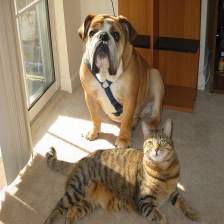

In [5]:
# Let's first take a look at the image, which we source from the GradCAM package

url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
Image.open(requests.get(url, stream=True).raw)

In [6]:
# Cute, isn't it? Do you prefer dogs or cats?

# We will need to convert the image into a tensor to feed it into the model.
# Let's create a function to do this for us.
def load_image(url):
    rgb_img = np.array(Image.open(requests.get(url, stream=True).raw))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img).to(device)
    return input_tensor, rgb_img

In [7]:
input_tensor, rgb_image = load_image(url)

### Grad-CAM Time!

In [8]:
# Let's start by selecting which layers of the model we want to use to generate the CAM.
# For that, we will need to inspect the model architecture.
# We can do that by simply printing the model object.
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Here we want to interpret what the model as a whole is doing (not what a specific layer is doing).
That means that we want to use the embeddings of the last layer before the final classification layer.
This is the layer that contains the information about the image encoded by the model as a whole.

Looking at the model, we can see that the last layer before the final classification layer is `layer4`.

In [9]:
target_layers = [model.layer4]

We also want to pick a label for the CAM - this is the class we want to visualize the activation for.
Essentially, we want to see what the model is looking at when it is predicting a certain class.

Since ResNet was trained on the ImageNet dataset with 1000 classes, let's get an indexed list of those classes. We can then pick the index of the class we want to visualize.

In [10]:
imagenet_categories_url = \
     "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
labels = eval(requests.get(imagenet_categories_url).text)
labels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

Well, that's a lot! To simplify things, we have already picked out the indices of a few interesting classes.

- 157: Siberian Husky
- 162: Beagle
- 245: French Bulldog
- 281: Tabby Cat
- 285: Egyptian cat
- 360: Otter
- 537: Dog Sleigh
- 799: Sliding Door
- 918: Street Sign

In [11]:
# Specify the target class for visualization here. If you set this to None, the class with the highest score from the model will automatically be used.
visualized_class_id = 245

In [15]:
def viz_gradcam(model, target_layers, class_id):

  if class_id is None:
    targets = None
  else:
    targets = [ClassifierOutputTarget(class_id)]

  cam_algorithm = GradCAM
  with cam_algorithm(model=model, target_layers=target_layers) as cam:
      grayscale_cam = cam(input_tensor=input_tensor,
                          targets=targets)

      grayscale_cam = grayscale_cam[0, :]

      cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
      cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

  cv2_imshow(cam_image)

Finally, we can start visualizing! Let's begin by seeing what parts of the image the model looks at to make its most confident prediction.

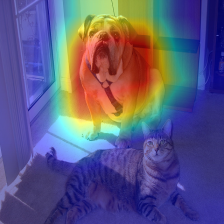

In [16]:
viz_gradcam(model=model, target_layers=target_layers, class_id=None)

Interesting, it looks like the model totally ignores the cat and makes a prediction based on the dog.
If we set the output class to "French Bulldog" (`class_id=245`), we see the same visualization - meaning that the model is indeed looking at the correct part of the image to make the correct prediction.

Let's see what the heatmap looks like when we force the model to look at the cat.

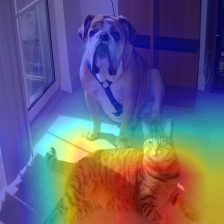

In [17]:
viz_gradcam(model=model, target_layers=target_layers, class_id=281)

The model is indeed looking at the cat when asked to predict the class "Tabby Cat" (`class_id=281`)!
But why is it still predicting the dog? Well, the model was trained on the ImageNet dataset, which contains a lot of images of dogs and cats.
The model has learned that the dog is a better indicator of the class "Tabby Cat" than the cat itself.

Let's see another example of this. The image has not only a dog and a cat, but also a items in the background. Can the model correctly identify the door?

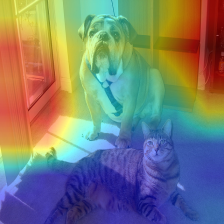

In [19]:
viz_gradcam(model=model, target_layers=target_layers, class_id=799)

It can! However, it seems to also think of the shelf behind the dog as a door.

Let's try an unrelated object now. Where in the image does the model see a street sign?

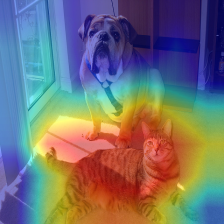

In [21]:
viz_gradcam(model=model, target_layers=target_layers, class_id=918)

Looks like our analysis has revealed a shortcoming of the model! It seems to percieve cats and street signs similarly.

Ideally, when the target class is some unrelated object, a good model will look at no significant part of the image. For example, the model does a good job with the class for Dog Sleigh.

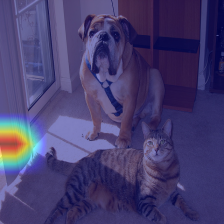

In [25]:
viz_gradcam(model=model, target_layers=target_layers, class_id=537)

Explaining model predictions though visualization techniques like this can be very subjective and prone to error. However, this still provides some degree of insight a completely black box model would not provide.

Spend some time playing around with different classes and seeing which part of the image the model looks at. Feel free to play around with other base images as well. Have fun!